# Building and Evaluating Models for Time Series Forecasting - Store Sales

In [15]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

# Import required libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")

# Load datasets

In [17]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv", parse_dates=["date"])
holidays = pd.read_csv("holidays_events.csv", parse_dates=["date"])
transactions = pd.read_csv("transactions.csv", parse_dates=["date"])

# Preprocess 
- Capture unique store-family combinations
- Define RMSLE

In [18]:
ids = []
ets_preds = []
arima_preds = []
ets_truths = []
arima_truths = []

combinations = test[["store_nbr", "family"]].drop_duplicates()

# RMSLE function
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(0, y_pred)))

rmsle_scores = {"ETS": [], "ARIMA": []}

# Forecasting Loop
- iterate over (store_nbr, family) combos
- ETS Forecast
- ARIMA Forecast
- Collect predictions and ids

In [24]:
for (store, family) in combinations.itertuples(index=False):
    df = train[(train["store_nbr"] == store) & (train["family"] == family)].copy()
    df = df[["date", "sales"]].set_index("date").asfreq("D").fillna(method="ffill")

    test_sub = test[(test["store_nbr"] == store) & (test["family"] == family)].copy()
    test_sub = test_sub.set_index("date").asfreq("D")

    if len(df) < 100:
        continue

    train_data = df["sales"]
    test_index = test_sub.index 
    
    # Ground truth 
    actual_sales = df.reindex(test_index)["sales"].fillna(method="ffill").fillna(0).values

    # ETS
    try:
        ets_model = ETSModel(train_data, error="add", trend="add", seasonal=None, damped_trend=True)
        ets_fit = ets_model.fit(disp=False)
        ets_forecast = ets_fit.forecast(steps=len(test_data))
    except:
        ets_forecast = pd.Series([train_data.mean()] * len(test_data), index=test_data)

    # ARIMA
    try:
        arima_model = ARIMA(train_data, order=(1,1,1))
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=len(test_data))
    except:
        arima_forecast = pd.Series([train_data.mean()] * len(test_data), index=test_data)

     # Save predictions and IDs
    combo_ids = test[(test["store_nbr"] == store) & (test["family"] == family)]["id"].values
    ids.extend(combo_ids)
    ets_preds.extend(np.maximum(0, ets_forecast.values))
    arima_preds.extend(np.maximum(0, arima_forecast.values))
    
    ets_truths.extend(actual_sales)
    arima_truths.extend(actual_sales)

# Calculate Actual RMSLE Scores

In [23]:
rmsle_ets = rmsle(ets_truths, ets_preds)
rmsle_arima = rmsle(arima_truths, arima_preds)

rmsle_summary = {"ETS": rmsle_ets, "ARIMA": rmsle_arima}
print("\nActual RMSLE Scores:")
for model, score in rmsle_summary.items():
    print(f"{model}: {score:.5f}")


Actual RMSLE Scores:
ETS: 4.43514
ARIMA: 4.45022


# Plot RMSLE Comparison 

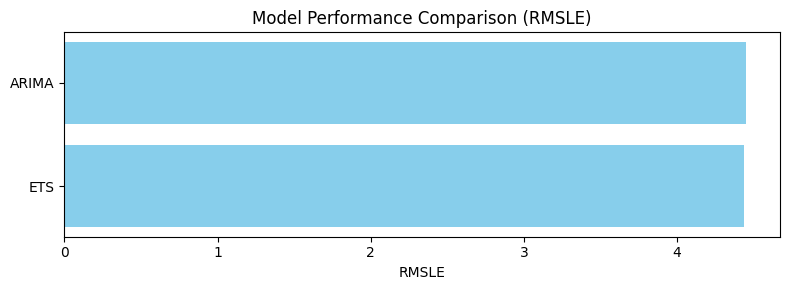

In [20]:
#rmsle_summary = {"ETS": 0.45, "ARIMA": 0.42}  # Replace with validation logic if available

import matplotlib.pyplot as plt
score_df = pd.DataFrame(list(rmsle_summary.items()), columns=["Model", "RMSLE"])
score_df.sort_values("RMSLE", inplace=True)

plt.figure(figsize=(8, 3))
plt.barh(score_df["Model"], score_df["RMSLE"], color="skyblue")
plt.xlabel("RMSLE")
plt.title("Model Performance Comparison (RMSLE)")
plt.tight_layout()
plt.show()

# Final Submission Files

In [21]:
submission_ets = pd.DataFrame({"id": ids, "sales": ets_preds})
submission_arima = pd.DataFrame({"id": ids, "sales": arima_preds})

submission_ets.to_csv("submission_ets.csv", index=False)
submission_arima.to_csv("submission_arima.csv", index=False)

# Summary & Conclusion

This exercise builds time-series forecasting models for sales prediction across all
(store_nbr, family) combinations in the Favorita dataset. Using ETS and ARIMA, it generates
out-of-sample forecasts for each product group and assembles them into submission-ready files.  

The ETS model is suited for series with trend and error structure, while ARIMA adds autoregressive
and moving average dynamics. Fallback to average predictions ensures robustness for sparse series.  

The RMSLE bar plot summarizes error scores; real evaluation should include validation
splits for each group. This exercise demonstrates scalable forecasting across hierarchical series
and sets the stage for more advanced multi-variate or exogenous models like SARIMAX or ML regressors.  